# TangMingcan A0176580X


# Introduction


**ASSIGNMENT DEADLINE: 4 MAR 2018 (SUN) 17:00PM**

In this assignment we will be coding the building blocks for the convolutional neural network and putting them together to train a CNN on the MNIST dataset.

**Attention: Only python3 will be allowed to use in this assignment. And we use `numpy` to store and caculate data and parameters. You do not need a GPU to for this assignment. CPU is enough. To run this Jupyter notebook, you need to install the depedent libraries in [requiremets.txt](requirements.txt) via pip (or pip3). Note: keras version should be >=2.1.2. Please do not run this whole file before you implement all the codes. Otherwise it will occur some error.**

For each layer we will implement a forward and a backward function. The forward function will receive inputs and will return the outputs of this layer(loss layer will be a little different), like this:

```python
def forward(self, inputs):
  """ Receive inputs and return output"""
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  outputs = # the outputs
    
  return outputs
```

The backward pass will receive upstream derivatives and inputs, and will return gradients with respect to the inputs. Gradients for weights or bias will be stored in parameters in this layer , like this:

```python
def backward(self, in_grads, inputs):
  """
  Receive derivative of loss with respect to outputs,
  and compute derivative with respect to inputs.
  """
  # Use values in cache to compute derivatives
  out_grads = # Derivative of loss with respect to inputs
  self.w_grad = # Derivative of loss with respect to self.weights
  self.b_grad = # Derivative of loss with respect to self.bias
    
  return out_grads
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

This iPython notebook serves to:

- explain the questions
- explain the function APIs and implementation examples (like `ReLU`) 
- provide helper functions to piece functions together and check your code

# ReLU layer
A convolution layer is usually followed by a non-linear activation function. We will provide the functions `forward` and `backward` of class `ReLU` in `layers.py` as an implementation example. Read through the function code and make sure you understand the derivation. Besides, we will explain the implementation of `ReLU` after `Convolution` using formula. You need to write down other layers' formulations in your reports.

## Forward Formulation
Given input $x \in R^{B \times C \times H \times W}$ ($B$:batch size, $C$: number of channel, $H$: input height, $W$: input width),  output $y \in R^{B \times C \times H \times W}$ will be caculated like this:

\begin{equation*}
y=idicator(x) \times x
\end{equation*}

Here, $indicator(x)$ return the same size of input $x$, comparing $x$ with 0 element-wisely. If $x_{i,j,k,l} \geq 0$ return $z_{i,j,k,l}=1$. And the multiplication is also element-wise. If the input $x$ has only 2 dimensions, i.e. the batch dimension and the feature dimension, e.g. after the FC layer, the subscripts $j,k,l$ in the formula are merged into one $j$.

## Backward Formulation
Given input $x \in R^{B \times C \times H \times W}$ ($B$:batch size, $C$: number of channel, $H$: input height, $W$: input width) and gradients to output of this layer $dy \in R^{B \times C \times H \times W}$, gradients to input $dx$ will be caculated like this:

\begin{equation*}
dx=idicator(x) \times dy
\end{equation*}

# Covolution Layer
In the file `layers.py`, the class `Convolution` will be initialized with `conv_params`, `initializer` and `name`, shown as below:
```python
def __init__(self, in_features, out_features, name='fclayer', initializer=Guassian()):
        super(FCLayer, self).__init__(name=name)
        self.trainable = True
        self.weights = initializer.initialize((in_features, out_features))
        self.bias = initializer.initialize(out_features)

        self.w_grad = np.zeros(self.weights.shape)
        self.b_grad = np.zeros(self.bias.shape)
```

`conv_params` is a dictionary, containing these parameters:

- 'kernel_h': The height of kernel.
- 'kernel_w': The width of kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The number of pixels padded to the bottom, top, left and right of each feature map. **Here, `pad=2` means a 2-pixel border padded with zeros**.
- 'in_channel': The number of input channels.
- 'out_channel': The number of output channels.

`initializer` is an instance of Initializer class (leave it out right now)

## Forward
In the file `layers.py`, implement the forward pass for a convolutional layer in the function `forward` of class `Convolution`.

The input consists of N data points, each with C channels, height H and width W. We convolve each input with K different kernels, where each filter spans all C channels and has height HH and width WW.

Input:

- inputs: Input data of shape (N, C, H, W)

**WARNING:** Please implement the matrix product method of convolution as shown in Lecture notes. The naive version of implementing a sliding window will be too slow when you try to train the whole CNN in later sections.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [1]:
import numpy as np
from layers import Convolution
from utils.tools import rel_error

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

inputs = np.random.uniform(size=(10, 3, 29, 29))
params = { 'kernel_h': 5,
          'kernel_w': 5,
          'pad': 0,
          'stride': 2,
          'in_channel': inputs.shape[1],
          'out_channel': 64,
}
layer = Convolution(params)
out = layer.forward(inputs)

keras_model = keras.Sequential()
keras_layer = layers.Conv2D(filters=params['out_channel'],
                            kernel_size=(params['kernel_h'], params['kernel_w']),
                            strides=(params['stride'], params['stride']),
                            padding='valid',
                            data_format='channels_first',
                            input_shape=inputs.shape[1:])
keras_model.add(keras_layer)
sgd = optimizers.SGD(lr=0.01)
keras_model.compile(loss='mean_squared_error', optimizer='sgd')
weights = np.transpose(layer.weights, (2, 3, 1, 0))
keras_layer.set_weights([weights, layer.bias])
keras_out = keras_model.predict(inputs, batch_size=inputs.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))
#out1=layer.backward(out,inputs)
#print(out1)

Using TensorFlow backend.


Relative error (<1e-6 will be fine):  4.85713792247e-07


## Backward
Implement the backward pass for the convolution operation in the function `backward` of `Convolution` class in the file `layers.py`. 

When you are done, restart jupyter notebook and run the following to check your backward pass with a numeric gradient check. 

In gradient checking, to get an approximate gradient for a parameter, we vary that parameter by a small amount (while keeping rest of parameters constant) and note the difference in the network loss. Dividing the difference in network loss by the amount we varied the parameter gives us an approximation for the gradient. We repeat this process for all the other parameters to obtain our numerical gradient. Note that gradient checking is a slow process (2 forward propagations per parameter) and should only be used to check your backpropagation!

More links on gradient checking:

http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/

https://www.coursera.org/learn/machine-learning/lecture/Y3s6r/gradient-checking

In [14]:
from layers import Convolution
import numpy as np
from utils.check_grads import check_grads_layer
from utils.tools import *

batch = 10
conv_params={
    'kernel_h': 2,
    'kernel_w': 2,
    'pad': 0,
    'stride': 2,
    'in_channel': 3,
    'out_channel': 10
}
in_height = 10
in_width = 20
out_height = 1+(in_height+2*conv_params['pad']-conv_params['kernel_h'])//conv_params['stride']
out_width = 1+(in_width+2*conv_params['pad']-conv_params['kernel_w'])//conv_params['stride']
inputs = np.random.uniform(size=(batch, conv_params['in_channel'], in_height, in_width))
in_grads = np.random.uniform(size=(batch, conv_params['out_channel'], out_height, out_width))
conv = Convolution(conv_params,initializer=MEAN())
check_grads_layer(conv, inputs, in_grads)

<1e-8 will be fine
Gradients to inputs: 2.92716236178e-11
Gradients to weights:  1.16809256591e-12
Gradients to bias:  6.3640546772e-12


# Dropout Layer
Dropout [1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In the file `layers.py`, the class `FCLayer` will be initialized with `ratio`, `seed` and `name`, shown as below:
```python
def __init__(self, ratio, name='dropout', seed=None):
        super(Dropout, self).__init__(name=name)
        self.ratio = ratio
        self.mask = None
        self.seed = seed
```

- `ratio`: The probability of setting a neuron to zero
- `seed`: Random seed to sample from inputs, so as to get mask. (default as None)

## Forward
In the file `layers.py`, implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.  `p` refers to the probability of setting a neuron to zero. We will follow the Caffe convention where we multiply the outputs by `1/(1-p)` during training. 

## Backward
In the file `layers.py`, implement the backward pass for dropout. After doing so, restart jupyter notebook and run the following cell to numerically gradient-check your implementation.

In [12]:
from layers import Dropout
import numpy as np
from utils.check_grads import check_grads_layer

ratio = 0.1
height = 10
width = 20
channel = 10
batch = 2
np.random.seed(1234)
inputs = np.random.uniform(size=(batch, channel, height, width))
in_grads = np.random.uniform(size=(batch, channel, height, width))
dropout = Dropout(ratio, seed=1234)
dropout.set_mode(True)
check_grads_layer(dropout, inputs, in_grads)

<1e-8 will be fine
Gradients to inputs: 2.15642719011e-13


# Pooling Layer
In the file `layers.py`, the class `Pooling` will be initialized with `pool_params`, and `name`, shown as below:
```python
def __init__(self, pool_params, name='pooling'):
        super(Pooling, self).__init__(name=name)
        self.pool_type = pool_params['pool_type']
        self.pool_height = pool_params['pool_height']
        self.pool_width = pool_params['pool_width']
        self.stride = pool_params['stride']
        self.pad = pool_params['pad']
```

`pool_params` is a dictionary, containing these parameters:
- 'pool_type': The type of pooling, 'max' or 'avg'
- 'pool_h': The height of pooling kernel.
- 'pool_w': The width of pooling kernel.
- 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
- 'pad': The number of pixels that will be used to zero-pad the input in each x-y direction. **Here, `pad=2` means a 2-pixel border of padding with zeros**.

## Forward
Implement the forward pass for the pooling operation in the function `forward` of class `Pooling` in the file `layers.py`.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [2]:
import numpy as np
from layers import Pooling
from utils.tools import rel_error
from utils.check_grads import check_grads_layer

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

inputs = np.random.uniform(size=(2, 3, 29, 29))
params = { 'pool_type': 'avg',
           'pool_height': 5,
           'pool_width': 5,
           'pad': 0,
           'stride': 2,
}
layer = Pooling(params)
out = layer.forward(inputs)

keras_model = keras.Sequential()
keras_layer = layers.AveragePooling2D(pool_size=(params['pool_height'], params['pool_width']),
                                 strides=params['stride'],
                                 padding='valid',
                                 data_format='channels_first',
                                 input_shape=inputs.shape[1:])
keras_model.add(keras_layer)
sgd = optimizers.SGD(lr=0.01)
keras_model.compile(loss='mean_squared_error', optimizer='sgd')
keras_out = keras_model.predict(inputs, batch_size=inputs.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))
in_grads = np.random.uniform(size=(2, 3, 13, 13))
check_grads_layer(layer, inputs, in_grads)

Relative error (<1e-6 will be fine):  3.31034078722e-08
<1e-8 will be fine
Gradients to inputs: 3.14669917309e-11


## Backward
Implement the backward pass for the max-pooling operation in the function `backward` of class `Pooling` in the file `layers.py`.

Please make sure you have implemented both ’max’ and ’avg’ pooing in your codes. And then test the gradients by yourself.

# FC Layer

FC layer (short for fully connected layer) is also called linear layer or dense layer.

In the file `layers.py`, the class `FCLayer` will be initialized with `in_features`, `out_features`, and `name`, shown as below:
```python
def __init__(self, in_features, out_features, name='fclayer', initializer=Guassian()):
        super(FCLayer, self).__init__(name=name)
        self.trainable = True
        self.weights = initializer.initialize((in_features, out_features))
        self.bias = initializer.initialize(out_features)

        self.w_grad = np.zeros(self.weights.shape)
        self.b_grad = np.zeros(self.bias.shape)
```

- `in_features`: The number of inputs features
- `out_features`: The numbet of required outputs features

## Forward
Implement the forward pass for the pooling operation in the function `forward` of class `FCLayer` in the file `layers.py`.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [16]:
import numpy as np
from layers import FCLayer
from utils.tools import rel_error

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

inputs = np.random.uniform(size=(10, 20))

layer = FCLayer(in_features=inputs.shape[1], out_features=100)
out = layer.forward(inputs)

keras_model = keras.Sequential()
keras_layer = layers.Dense(100, input_shape=inputs.shape[1:], use_bias=True, kernel_initializer='random_normal', bias_initializer='zeros')
# print (len(keras_layer.get_weights()))
keras_model.add(keras_layer)
sgd = optimizers.SGD(lr=0.01)
keras_model.compile(loss='mean_squared_error', optimizer='sgd')
keras_layer.set_weights([layer.weights, layer.bias])
keras_out = keras_model.predict(inputs, batch_size=inputs.shape[0])
print('Relative error (<1e-6 will be fine): ', rel_error(out, keras_out))
in_grads = np.random.uniform(size=(10,100))
check_grads_layer(layer, inputs, in_grads)

Relative error (<1e-6 will be fine):  1.75705998917e-07
<1e-8 will be fine
Gradients to inputs: 1.24986485013e-11
Gradients to weights:  8.63100319281e-13
Gradients to bias:  7.07660945e-13


## Backward
Implement the backward pass for the max-pooling operation in the function `backward` of class `FCLayer` in the file `layers.py`. Please test the gradients by yourself.

# SoftmaxCrossEntropy Loss
We write Softmax and CrossEntropy together because it can avoid some numeric overflow problem.In the file `loss.py`, the class `SoftmaxCrossEntropy` will be initialized with `num_class`,  shown as below:
```python
def __init__(self, num_class):
        super(SoftmaxCrossEntropy, self).__init__()
        self.num_class = num_class
```

`num_class`: The number of category

## Forward
Implement the forward pass for the pooling operation in the function `forward` of class `FCLayer` in the file `layers.py`.

You can test your implementation by restarting jupyter notebook kernel and running the following:

In [17]:
import numpy as np
from loss import SoftmaxCrossEntropy
from utils.tools import rel_error

import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

batch = 10
num_class = 10
inputs = np.random.uniform(size=(batch, num_class))
targets = np.random.randint(num_class, size=batch)

loss = SoftmaxCrossEntropy(num_class)
out, _ = loss.forward(inputs, targets)

keras_inputs = K.softmax(inputs)
keras_targets = np.zeros(inputs.shape, dtype='int')
for i in range(batch):
        keras_targets[i, targets[i]] = 1
keras_out = K.mean(K.categorical_crossentropy(keras_targets, keras_inputs, from_logits=False))
print('Relative error (<1e-6 will be fine): ', rel_error(out, K.eval(keras_out)))

Relative error (<1e-6 will be fine):  0.0


## Backward
In the file `loss.py`, implement the backward pass for `SodtmaxCrossEntropy`. Please test the gradients by yourself.

# Optimizer
In the file `optimizers.py`, there are 4 types of optimizer (`SGD`, `Adam`, `RMSprop` and `Adagrad`). You only need to implement the `update` function of `SGD`(mini-batch SGD with momentum) and `Adam`. These two types of optimizers are initialized like this:

```python
class SGD(Optimizer):
    def __init__(self, lr=0.01, momentum=0, decay=0, sheduler_func = None):
        super(SGD, self).__init__(lr)
        self.momentum = momentum
        self.moments = None
        self.decay = decay
        self.sheduler_func = sheduler_func
        
class Adam(Optimizer):
    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, sheduler_func=None):
        super(Adam, self).__init__(lr)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.decay = decay
        if not self.epsilon:
            self.epsilon = 1e-8
        self.moments = None
        self.accumulators = None
        self.sheduler_func = sheduler_func
```

For Both optimizers:
- `lr`: The initial learning rate.
- `decay`: The learning rate decay ratio
- `sheduler_func`: Function to change learning rate with respect to iterations

For `SGD`:
- `momentum`: The ratio of moments


For `Adam`:
More details can be seen in reference.

**For you reference:**
http://cs231n.github.io/neural-networks-3/#update

# Train the net on full MNIST data
By training the `MNISTNet` for one epoch, you should achieve about 90% on the validation and test set. You may have to wait about 5 minutes for training to be completed.

Number of training images:  48000
Number of validation images:  12000
Number of testing images:  10000

Four examples of training images:


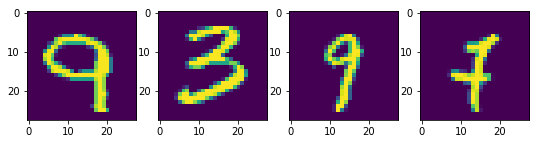

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from applications import MNISTNet
from loss import SoftmaxCrossEntropy, L2
from optimizers import Adam
from utils.datsets import MNIST
import numpy as np

mnist = MNIST()
mnist.load()
idx = np.random.randint(mnist.num_train, size=4)
print('\nFour examples of training images:')
img = mnist.x_train[idx][:,0,:,:]

plt.figure(1, figsize=(9, 9))
plt.subplot(1, 4, 1)
plt.imshow(img[0])
plt.subplot(1, 4, 2)
plt.imshow(img[1])
plt.subplot(1, 4, 3)
plt.imshow(img[2])
plt.subplot(1, 4, 4)
plt.imshow(img[3])

In [3]:
import numpy as np
from loss import SoftmaxCrossEntropy
from utils.tools import rel_error

%matplotlib inline
import matplotlib.pyplot as plt
from applications import MNISTNet
from loss import SoftmaxCrossEntropy, L2
from optimizers import Adam
from utils.datsets import MNIST

import warnings
warnings.filterwarnings('ignore')


mnist = MNIST()
mnist.load()

model = MNISTNet()
loss = SoftmaxCrossEntropy(num_class=10)



# define your learning rate sheduler
def func(lr, iteration):
    if iteration % 1000 ==0:
        return lr*0.5
    else:
        return lr

Number of training images:  48000
Number of validation images:  12000
Number of testing images:  10000


In [ ]:
adam = Adam(lr=0.1, decay=1e-6,  sheduler_func = func)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001

model.compile(optimizer=adam, loss=loss, regularization=l2)
train_results, val_results, test_results = model.train(
    mnist, 
    train_batch=64, val_batch=1000, test_batch=1000, 
    epochs=4, 
    val_intervals=100, test_intervals=300, print_intervals=100)

In [ ]:
import pickle
pickle.dump([train_results, val_results, test_results], 
            open(r"/Users/aarontom/DeepLearning/Assignment 1/0.1_1e-6_0.001_64_4_all.pickle.dat", "wb"))
pickle.dump(model, 
            open(r"/Users/aarontom/DeepLearning/Assignment 1/model.pickle", "wb"))

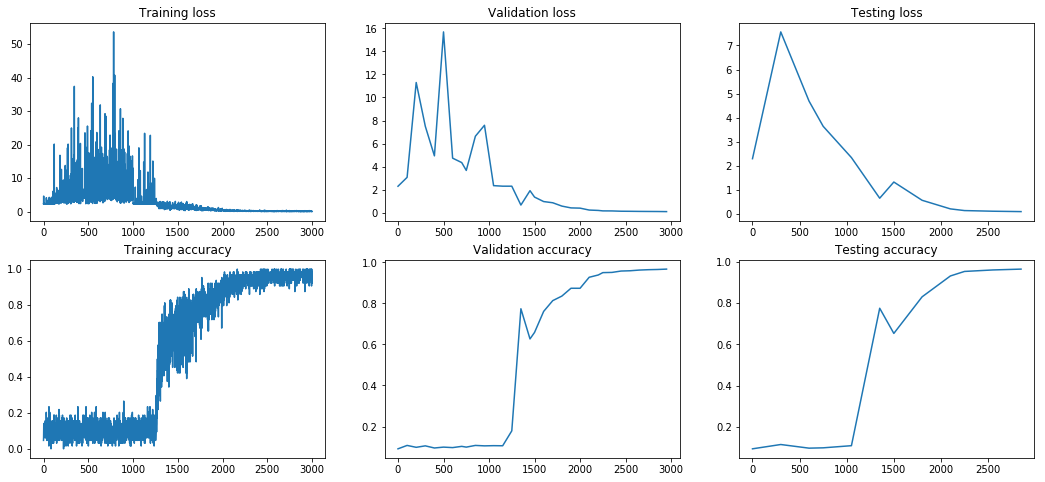

In [4]:
import pickle
train_results, val_results, test_results=pickle.load(
    open(r"/Users/aarontom/DeepLearning/Assignment 1/0.1_1e-6_0.001_64_4_all.pickle.dat", "rb"))
model=pickle.load(
    open(r"/Users/aarontom/DeepLearning/Assignment 1/model.pickle", "rb"))
plt.figure(2, figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.title('Training loss')
plt.plot(train_results[:,0], train_results[:,1])
plt.subplot(2, 3, 4)
plt.title('Training accuracy')
plt.plot(train_results[:,0], train_results[:,2])
plt.subplot(2, 3, 2)
plt.title('Validation loss')
plt.plot(val_results[:,0], val_results[:,1])
plt.subplot(2, 3, 5)
plt.title('Validation accuracy')
plt.plot(val_results[:,0], val_results[:,2])
plt.subplot(2, 3, 3)
plt.title('Testing loss')
plt.plot(test_results[:,0], test_results[:, 1])
plt.subplot(2, 3, 6)
plt.title('Testing accuracy')
plt.plot(test_results[:, 0], test_results[:,2])

Let's have a look at the performance of our test dataset.

In [5]:
xtest,ytest=mnist.get_test()
yhat=np.argmax(model.predict_prob(xtest,ytest),axis=1)

We use TSNE to plot test dataset.

In [5]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
testX_reduced = tsne.fit_transform(xtest.reshape(xtest.shape[0],-1))

In [16]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10),add=False):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    if add is False:
        plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=cmap(digit / 9))
    if add is False:
        plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

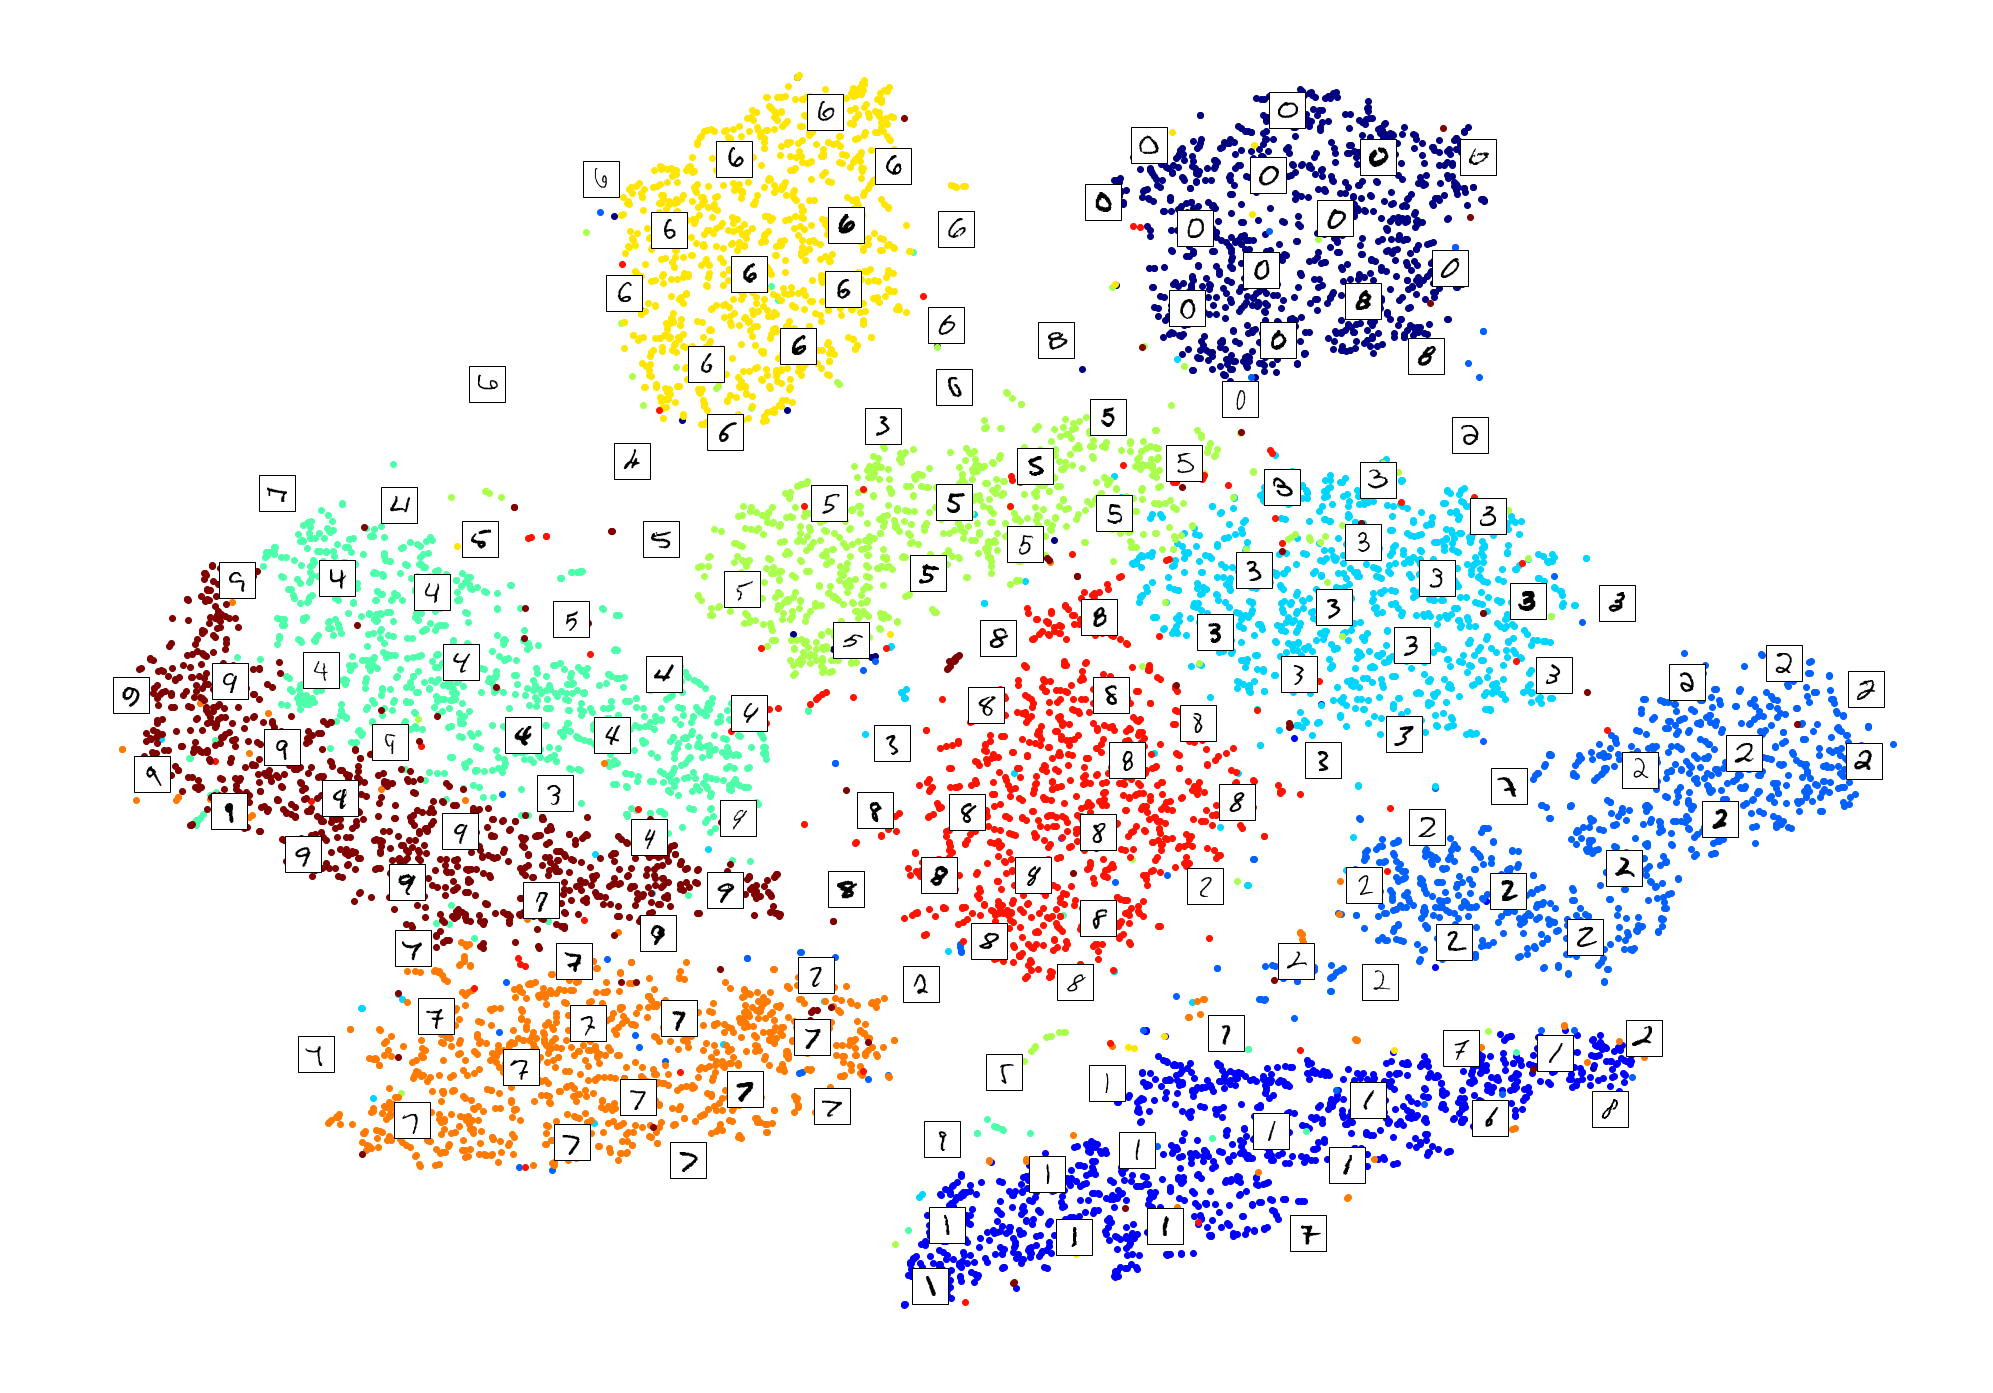

In [7]:
import matplotlib

plot_digits(testX_reduced,ytest,images=xtest.reshape(xtest.shape[0],-1), figsize=(35,25))
plt.show()

We also can use the plotly library to draw a 3d pic with predicted and actual values for comparision.

In [9]:
from plotly.offline import iplot,init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

trace0 = go.Scatter3d(
    x=testX_reduced[yhat!=ytest][:, 0], 
    y=testX_reduced[yhat!=ytest][:, 1],
    z=ytest[yhat!=ytest],
    text=['yhat:'+str(a) for a in yhat[yhat!=ytest]],
    mode='markers',
    name='Yhat',
    marker=dict(
        size=3,
        color=yhat[yhat!=ytest], # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=1
    )
)
trace1 = go.Scatter3d(
    x=testX_reduced[:, 0], 
    y=testX_reduced[:, 1], 
    z=ytest,
    text=['ytest:'+str(a) for a in ytest],
    mode='markers',
    name='ytest',
    marker=dict(
        size=3,
        color=ytest,       # set color to an array/list of desired values
        colorscale='Jet',   # choose a colorscale
        opacity=0.1
    )
)
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    xaxis=dict(zeroline = False),
    yaxis=dict(zeroline = False)
)
fig = go.Figure(data=[trace0,trace1])#, layout=layout)
iplot(fig)

[[ 965    1    3    0    0    2    1    2    5    1]
 [   0 1120    3    3    3    1    2    0    3    0]
 [   4    3  992    8    2    0    5    4   13    1]
 [   1    0    3  981    0   10    0    4    8    3]
 [   2    0    1    0  956    0    5    2    2   14]
 [   4    0    0   12    0  870    2    0    3    1]
 [  13    4    2    0    5    6  925    0    3    0]
 [   0    4   26    3    1    0    0  985    3    6]
 [   3    1    5   12    3    2    1    4  938    5]
 [   4    6    1   10    5    4    0   10   10  959]]


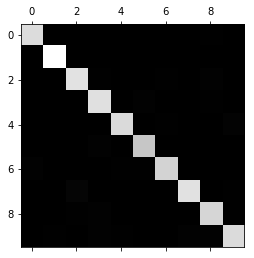

In [62]:
from sklearn.metrics import confusion_matrix
conf_mx=confusion_matrix(ytest,yhat)
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks fairly good, since most images are on the main diagonal, which means that they were classified correctly. The 5s, 8s and 9s look slightly darker than the other digits, which could mean that there are fewer images of 5s, 8s and 9s in the dataset or that the classifier does not perform as well on 5s, 8s and 9s as on other digits. In fact, we can verify that both are the cases.

Let’s focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so we can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad):

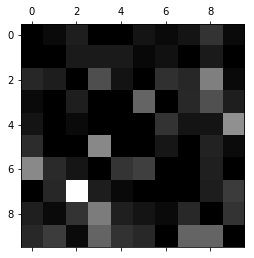

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Now we can clearly see the kinds of errors the classifier makes. Since rows represent actual classes, and columns represent predicted classes. 7s can easily predicted as 2s; The columns for classes 3, 8 and 9 are quite bright, which tells us that many images get misclassified as 3s, 8s or 9s. On the other hand, the rows for classes 8 and 9 are also quite bright, telling us that 8s and 9s are often misclassified. Conversely, some rows are pretty dark, such as row 1: this means that most 1s are classified correctly (only a few are confused with 6s). Notice that the errors are not perfectly symmetrical; for example, there are more 3s misclassified as 5s than the reverse.

Based on the above findings, we can find ways to improve our classifier in the future. It seems that our efforts should focus on imporoving classification of 8s and 9s, as well as fixing 3 and 5 confusion. For example, we can try to engineer new features that can count the number of closed loops among 6,8 and 5; or we can use preprocessing libries to intensify some significant patterns.

Next, we will also have a look at individual errors.

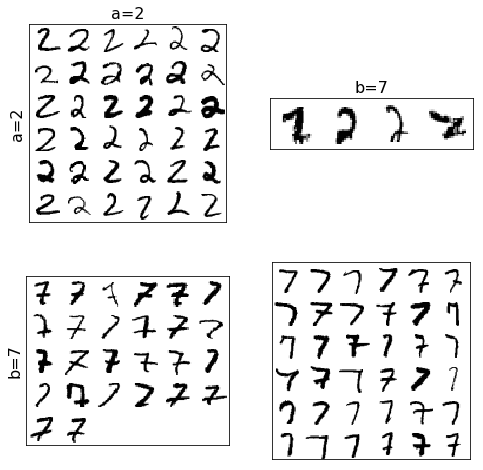

In [9]:
import matplotlib
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    #plt.axis("off")
    plt.xticks([])
    plt.yticks([])
    
a,b=2,7
X_aa=xtest[(ytest==a)&(yhat==a)]
X_ab=xtest[(ytest==a)&(yhat==b)]
X_ba=xtest[(ytest==b)&(yhat==a)]
X_bb=xtest[(ytest==b)&(yhat==b)]


plt.figure(figsize=(8,8))
plt.subplot(221)
plt.title(r"a={}".format(a), fontsize=16)
plot_digits(X_aa[:36],images_per_row=6)
plt.ylabel(r"a={}".format(a), fontsize=16, rotation=90)
plt.subplot(222)
plt.title(r"b={}".format(b), fontsize=16)
plot_digits(X_ab[:36],images_per_row=6)
plt.subplot(223)
plot_digits(X_ba[:36],images_per_row=6)
plt.ylabel(r"b={}".format(b), fontsize=16, rotation=90)
plt.subplot(224)
plot_digits(X_bb[:36],images_per_row=6)
plt.show()

We can see that even human can not recogoize some of the digits that the classifier gets wrong.

# Train your best MNISTNet!
Tweak the hyperparameters of the above MNISTNet and use what you've learnt to train the best net.

Credits will be given based on your test accuracy, your explanations/insights of the training. The network is small, hence the training should finish quickly using your CPU (less than 1 hour). 

Please report the following:
- Training validation and testing loss as well as accuracy over iterations
- Architecture and training method (eg. optimization scheme, data augmentation): explain your design choices, what has failed and what has worked and why you think they worked/failed
- Try different hyper-parameters, e.g. rate decaying, weight decay, number of layers and total number of epochs. 

Do NOT use external libraries like Tensorflow, keras and Pytorch in your implementation, i.e. optimizer.py, layer.py and loss.py. Do NOT copy the code from the internet, e.g. github. Do give credits to any material that you refer to for your implementation.

We tried different parameters using a parameters grid search. Below are our results.

In [6]:
import pickle
trainli=[]
valli=[]
testli=[]

def Append_li(file,i):
    global trainli,valli,testli
    train_r,val_r,test_r=pickle.load(
        open(file, "rb"))
    trainli.append(train_r)
    valli.append(val_r)
    testli.append(test_r)

    
files=[r"/Users/aarontom/DeepLearning/Assignment 1/0.001_1e-6_0.001_64_4_all_dr.pickle.dat", 
      r"/Users/aarontom/DeepLearning/Assignment 1/0.001_0_0.001_64_2_all.pickle.dat",
      r"/Users/aarontom/DeepLearning/Assignment 1/0.1_1e-6_0.01_30_2_all.pickle.dat",
      r"/Users/aarontom/DeepLearning/Assignment 1/0.1_1e-6_0.001_64_4_all.pickle.dat",
     ]
for i,file in enumerate(files):
    Append_li(file,i)

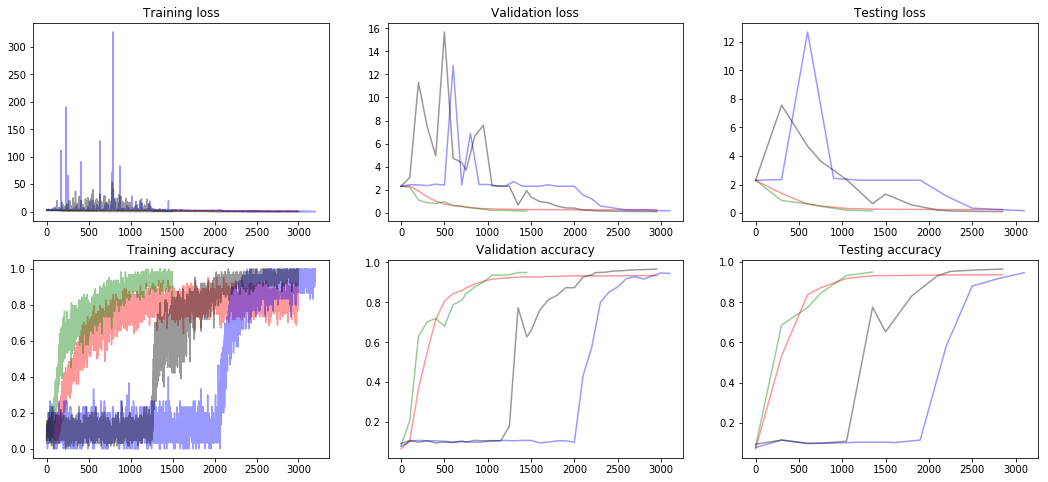

In [7]:
plt.figure(2, figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.title('Training loss')
plt.plot(trainli[0][:,0], trainli[0][:,1],color='r',alpha=0.4)
plt.plot(trainli[1][:,0], trainli[1][:,1],color='g',alpha=0.4)
plt.plot(trainli[2][:,0], trainli[2][:,1],color='b',alpha=0.4)
plt.plot(trainli[3][:,0], trainli[3][:,1],color='black',alpha=0.4)
plt.subplot(2, 3, 4)
plt.title('Training accuracy')
plt.plot(trainli[0][:,0], trainli[0][:,2],color='r',alpha=0.4)
plt.plot(trainli[1][:,0], trainli[1][:,2],color='g',alpha=0.4)
plt.plot(trainli[2][:,0], trainli[2][:,2],color='b',alpha=0.4)
plt.plot(trainli[3][:,0], trainli[3][:,2],color='black',alpha=0.4)
plt.subplot(2, 3, 2)
plt.title('Validation loss')
plt.plot(valli[0][:,0], valli[0][:,1],color='r',alpha=0.4)
plt.plot(valli[1][:,0], valli[1][:,1],color='g',alpha=0.4)
plt.plot(valli[2][:,0], valli[2][:,1],color='b',alpha=0.4)
plt.plot(valli[3][:,0], valli[3][:,1],color='black',alpha=0.4)
plt.subplot(2, 3, 5)
plt.title('Validation accuracy')
plt.plot(valli[0][:,0], valli[0][:,2],color='r',alpha=0.4)
plt.plot(valli[1][:,0], valli[1][:,2],color='g',alpha=0.4)
plt.plot(valli[2][:,0], valli[2][:,2],color='b',alpha=0.4)
plt.plot(valli[3][:,0], valli[3][:,2],color='black',alpha=0.4)
plt.subplot(2, 3, 3)
plt.title('Testing loss')
plt.plot(testli[0][:,0], testli[0][:, 1],color='r',alpha=0.4)
plt.plot(testli[1][:,0], testli[1][:, 1],color='g',alpha=0.4)
plt.plot(testli[2][:,0], testli[2][:, 1],color='b',alpha=0.4)
plt.plot(testli[3][:,0], testli[3][:, 1],color='black',alpha=0.4)
plt.subplot(2, 3, 6)
plt.title('Testing accuracy')
plt.plot(testli[0][:, 0], testli[0][:,2],color='r',alpha=0.4)
plt.plot(testli[1][:, 0], testli[1][:,2],color='g',alpha=0.4)
plt.plot(testli[2][:, 0], testli[2][:,2],color='b',alpha=0.4)
plt.plot(testli[3][:, 0], testli[3][:,2],color='black',alpha=0.4)
plt.show()

 color | lr      | decay    | w           | train_batch | epoch | use_2_drop_layers 
 ----- | ------- | -------- | ------------| ----------- | ----- | -------------------
 red   | 0.001   |   1e-6   |    0.001    |    64       |   4   |       True 
 green |   0.001 |   0 |      0.001 |       64 |          2 |       False 
  blue |    0.1 |    1e-6 |    0.01 |       30 |          2  |       False 
 black |   0.1 |     1e-6 |    0.001 |       64 |          4  |       False 

* Founding: Although lr=0.1, if the algorithm use a small decay number, it can still get a good result.
* This model is based on the mature NN architectures called LeNet, proposed by Yann le Cun (for more information refer to: Convolutional Networks for Images, Speech, and Time-Series, by Y.LeCun and Y.Bengio, brain theory neural networks, vol.3361, 1995), a family of ConvNets trained for recognizing MNIST handwritten characters with robustness to simple geometric transformations and to distortion. The key intuition here is to have low-layers alternation convolution operations with max-pooling operations. The convolution operations are based on carefully chosen local receptive fields with shared weights for multiple feature maps. Then higher levels are fully connected layers based on a traditional MLP with hidden layers and softmax as the output layer.  

# Data Augumentation

We notice that training data is imbalanced. Maybe it has some influence on the model. We try to oversample the minority classes to make the dataset balanced.

In [6]:
from scipy.stats import itemfreq
xtrain,ytrain=mnist.get_train()
print(itemfreq(ytrain))
mnist.get_balanced(ratio={0:7000,1:7000,2:7000,3:7000,4:7000,5:7000,6:7000,7:7000,8:7000,9:7000},k=5)
xtrain1,ytrain1=mnist.get_train()
print(itemfreq(ytrain1))

[[   0 4729]
 [   1 5470]
 [   2 4762]
 [   3 4889]
 [   4 4655]
 [   5 4324]
 [   6 4748]
 [   7 4968]
 [   8 4653]
 [   9 4802]]
[[   0 6999]
 [   1 7000]
 [   2 7000]
 [   3 7000]
 [   4 7000]
 [   5 7000]
 [   6 6999]
 [   7 6999]
 [   8 6999]
 [   9 7000]]


In [7]:
import pickle
pickle.dump([xtrain1, ytrain1], 
            open(r"/Users/aarontom/DeepLearning/Assignment 1/smotexy.pickle.dat", "wb"))

In [7]:
import pickle
xtrain1, ytrain1=pickle.load(
    open(r"/Users/aarontom/DeepLearning/Assignment 1/smotexy.pickle.dat", "rb"))

xtrain,ytrain=mnist.get_train()
xNew=set(map(tuple,xtrain1.reshape((-1,28*28))))-set(map(tuple,xtrain.reshape((-1,28*28))))
xNew=np.array([list(i) for i in xNew]).reshape((-1,1,28,28))

21996


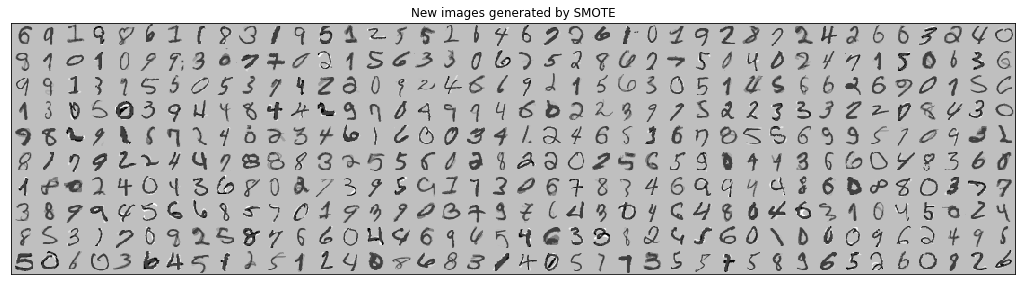

In [10]:
print(len(xNew))
plt.figure(figsize=(18,8))
plot_digits(xNew[:400],images_per_row=40)
plt.title('New images generated by SMOTE')
plt.show()

We found that the background of these images is not as clean as previous ones. Therefore, we should consider about contrasting images of both traing and test dataset.

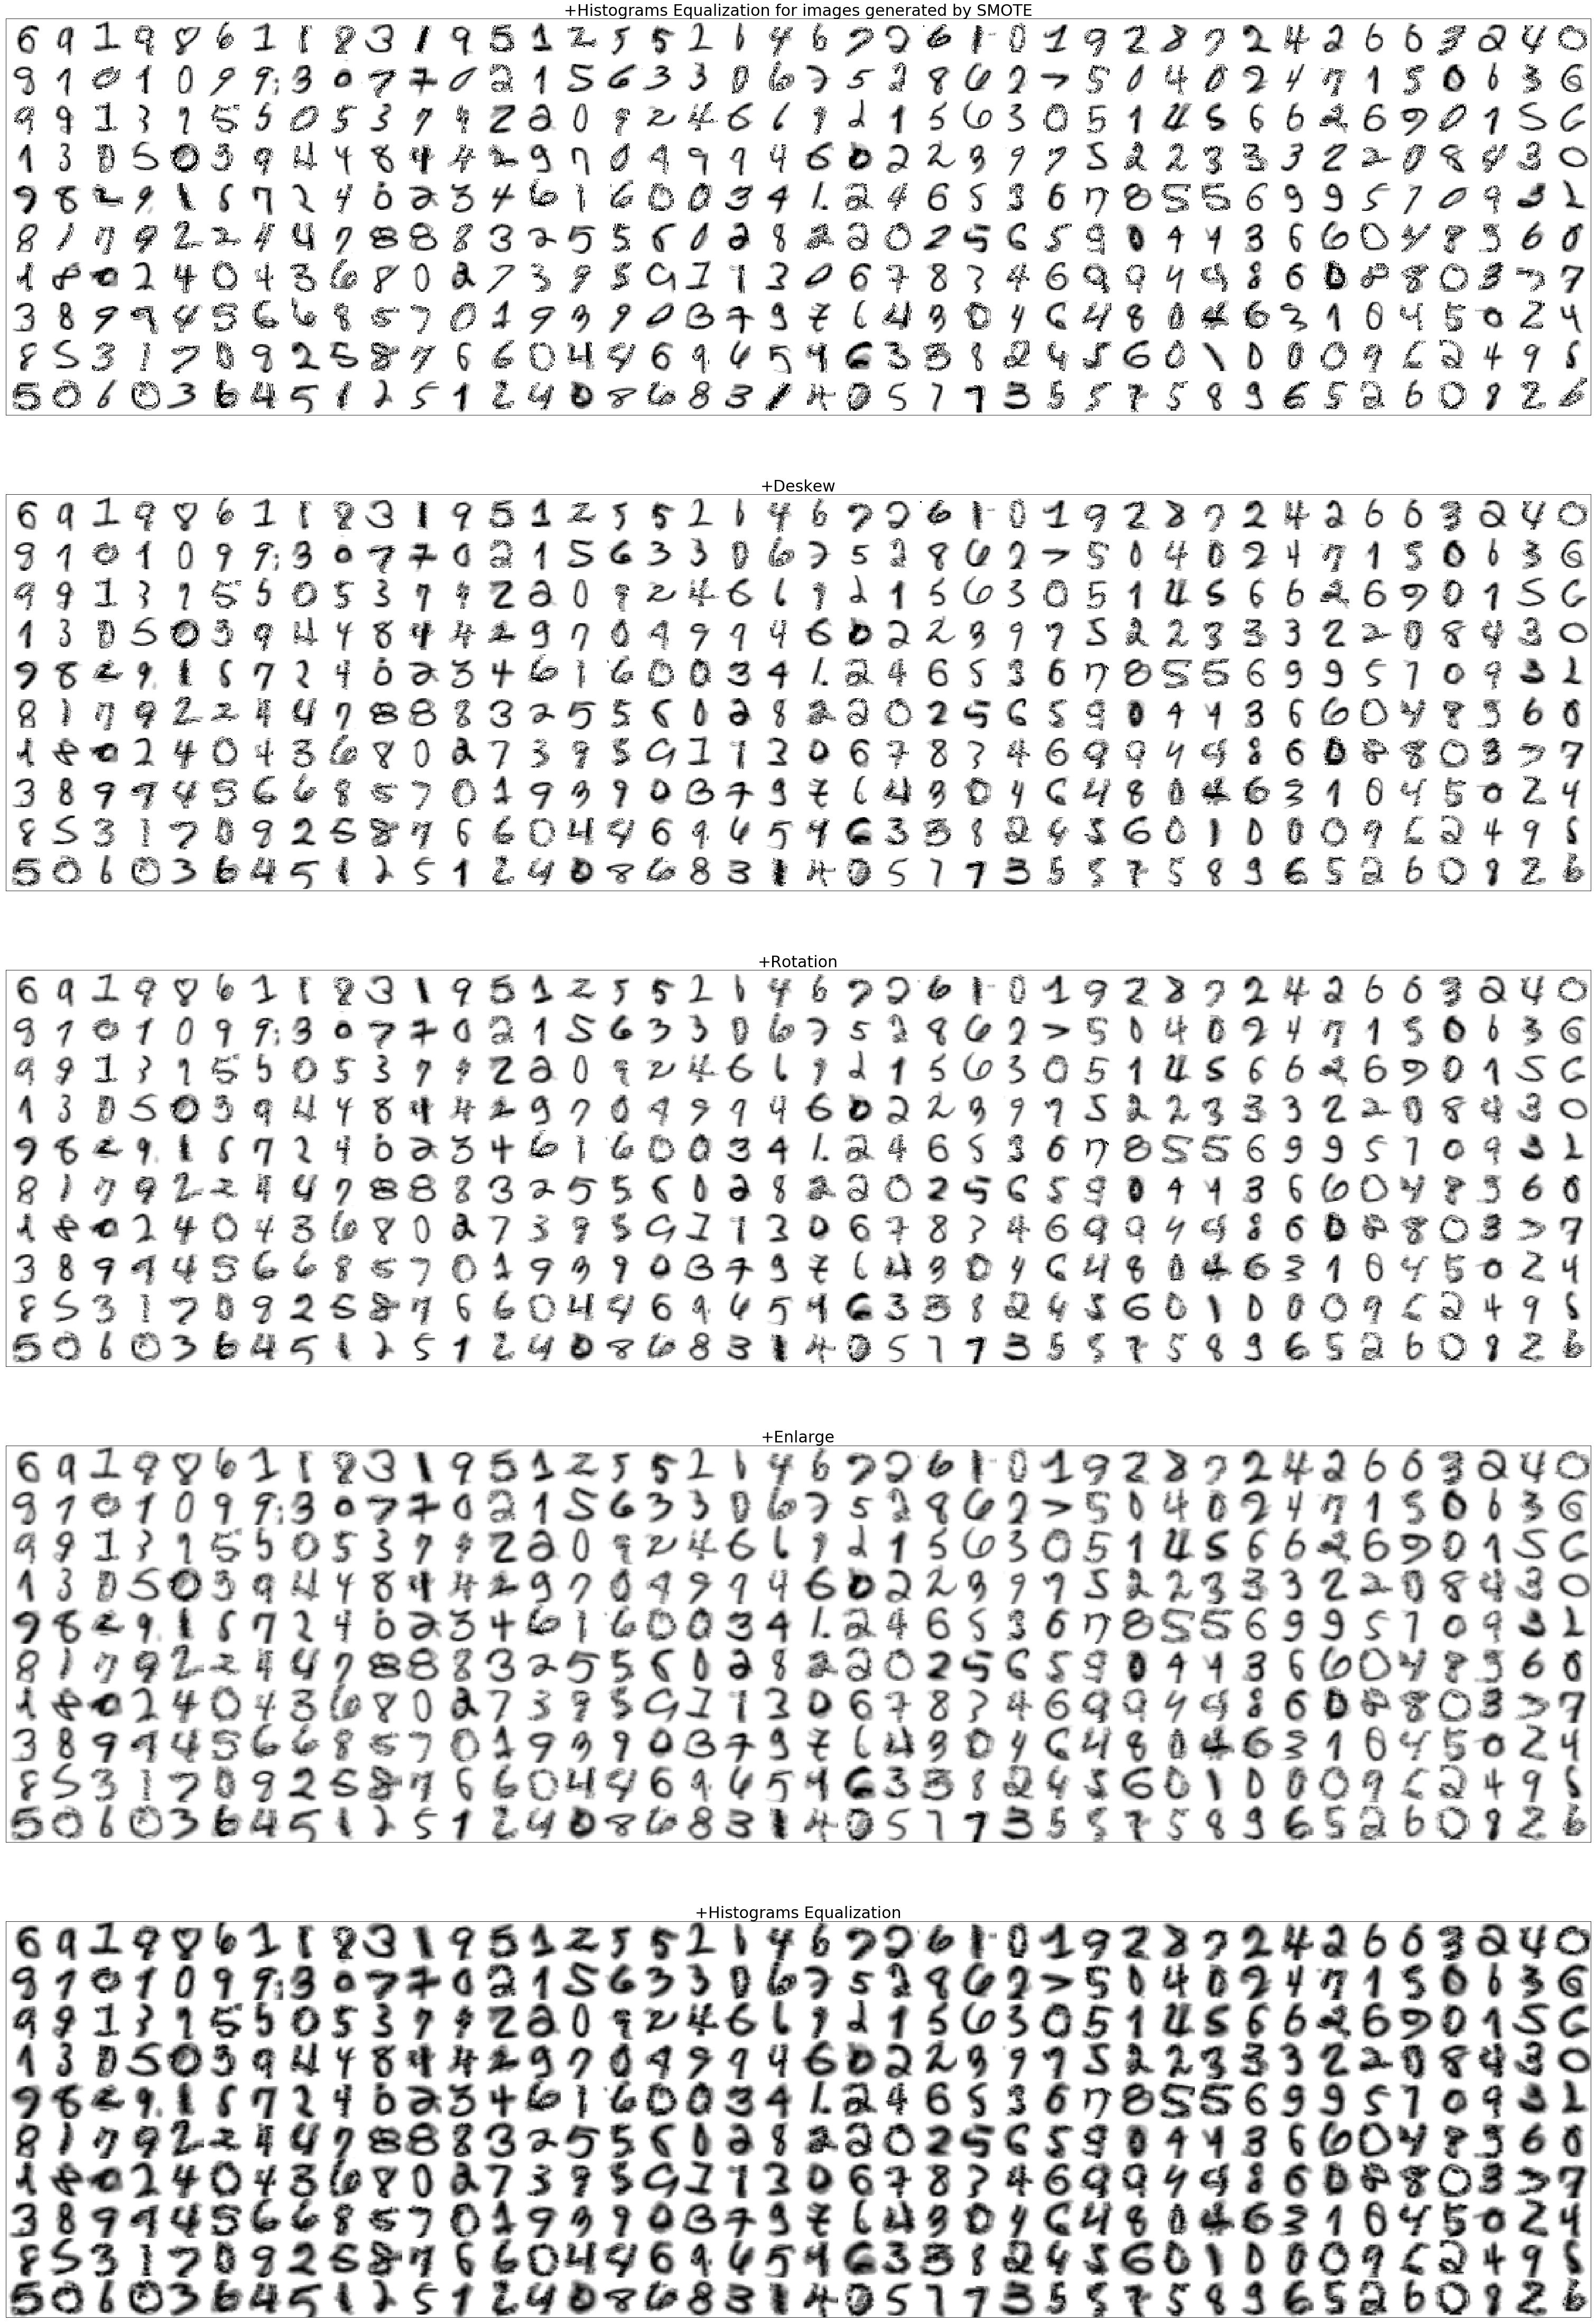

In [11]:
import cv2
import numpy as np
from random import randint,uniform

def contrast(x):
    x_=np.zeros_like(x)
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    for i in range(len(x)):
        #xNew1[i] = (clahe.apply((xNew[i]*255).astype(np.uint8).reshape((28,28)))/255).reshape((-1,28,28))
        x_[i]=(cv2.equalizeHist((x[i]*255).astype(np.uint8).reshape((28,28)))/255).reshape((-1,28,28))
    return x_

def rotate(x):
    x_=np.zeros_like(x)
    for i in range(len(x)):
        rows,cols=28,28
        x_[i]=cv2.warpAffine(x[i].reshape((28,28)),
                             cv2.getRotationMatrix2D((cols/2,rows/2),
                             randint(-15,15),1),(28,28)).reshape((-1,28,28))
    return x_

def scaling(x):
    x_=np.zeros_like(x)
    for i in range(len(x)):
        u=uniform(1.1,1.2)
        temp = cv2.resize(x[i].reshape((28,28)),
                           None,fx=u, fy=u, 
                           interpolation = cv2.INTER_LINEAR)
        w,h=int(temp.shape[0]/2),int(temp.shape[1]/2)
        x_[i]=temp[w-14:w+14,h-14:h+14].reshape((-1,28,28))

    return x_

SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
def deskew(x):
    x_=np.zeros_like(x)
    for i in range(len(x)):
        img=x[i].reshape((28,28))
        m=cv2.moments(img)
        if abs(m['mu02'])<1e-2:
            x_[i]=x[i].copy()
            continue
        skew=m['mu11']/m['mu02']
        M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
        x_[i]=cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags).reshape((-1,28,28))
    
    return x_

xNew1=contrast(xNew[:400])
plt.figure(figsize=(300,80))
plt.subplot(5,1,1)
plot_digits(xNew1,images_per_row=40)
plt.title('+Histograms Equalization for images generated by SMOTE', fontsize=30)

xNew2=deskew(xNew1)
plt.subplot(5,1,2)
plot_digits(xNew2,images_per_row=40)
plt.title('+Deskew', fontsize=30)

xNew3=rotate(xNew2)
plt.subplot(5,1,3)
plot_digits(xNew3,images_per_row=40)
plt.title('+Rotation', fontsize=30)

xNew4=scaling(xNew3)
plt.subplot(5,1,4)
plot_digits(xNew4,images_per_row=40)
plt.title('+Enlarge', fontsize=30)

xNew5=contrast(xNew4)
plt.subplot(5,1,5)
plot_digits(xNew5,images_per_row=40)
plt.title('+Histograms Equalization', fontsize=30)


plt.show()
xtrain1_=contrast(xtrain1)
xtrain1_=deskew(xtrain1)
xtrain1_=rotate(xtrain1_)
xtrain1_=scaling(xtrain1_)
xtrain1_=contrast(xtrain1_)

mnist.set_deskew()
mnist.set_contrast()

In [18]:
adam = Adam(lr=0.01, decay=1e-6,  sheduler_func = func)
l2 = L2(w=0.001) # L2 regularization with lambda=0.001
model1 = MNISTNet()

mnist.set_deskew()
mnist.set_contrast()
mnist.set_trainxy(np.append(xtrain1,xtrain1_,axis=0),np.append(ytrain1,ytrain1,axis=0))

model1.compile(optimizer=adam, loss=loss, regularization=l2)
train_results1, val_results1, test_results1 = model1.train(
    mnist, 
    train_batch=128, val_batch=1000, test_batch=1000, 
    epochs=6, 
    val_intervals=100, test_intervals=300, print_intervals=100)

Epoch 0: 
Test accuracy=0.11070, loss=2.30259
Validation accuracy: 0.11067, loss: 2.30259
Iteration 0:	accuracy=0.11719, loss=2.30259, regularization loss= 0.0052479340273
Validation accuracy: 0.51058, loss: 1.49214
Iteration 100:	accuracy=0.39062, loss=1.65041, regularization loss= 0.0367852183535
Validation accuracy: 0.83025, loss: 0.60167
Iteration 200:	accuracy=0.76562, loss=0.71849, regularization loss= 0.106822440133
Test accuracy=0.89800, loss=0.35412
Validation accuracy: 0.89567, loss: 0.34891
Iteration 300:	accuracy=0.85938, loss=0.58087, regularization loss= 0.153769060628
Epoch 1: 
Test accuracy=0.91200, loss=0.28035
Validation accuracy: 0.90908, loss: 0.28128
Iteration 0:	accuracy=0.87500, loss=0.35143, regularization loss= 0.169270488057
Validation accuracy: 0.86400, loss: 0.43408
Iteration 100:	accuracy=0.87500, loss=0.35893, regularization loss= 0.181816044683
Validation accuracy: 0.92325, loss: 0.24934
Iteration 200:	accuracy=0.95312, loss=0.13978, regularization loss= 

[[ 964    0    1    1    0    2    5    1    6    0]
 [   1 1118    1    7    0    1    1    0    6    0]
 [   1    2 1009    9    0    0    1    7    3    0]
 [   0    0    0 1005    0    1    0    2    0    2]
 [   2    1    2    1  954    0    4    2    2   14]
 [   1    0    1   29    0  853    2    2    4    0]
 [   8    5    1    0    2    9  931    0    2    0]
 [   1    1   13    6    0    2    0 1001    0    4]
 [   3    0    4    6    0    1    0    4  953    3]
 [   3    0    1   14    3    1    0    3    6  978]]


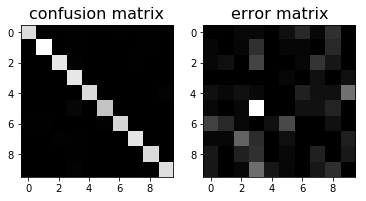

In [19]:
xtest,ytest=mnist.get_test()

yhat1=np.argmax(model1.predict_prob(xtest,ytest),axis=1)

from sklearn.metrics import confusion_matrix

conf_mx1=confusion_matrix(ytest,yhat1)
print(conf_mx1)
plt.subplot(1,2,1)
plt.title("confusion matrix", fontsize=16)
plt.imshow(conf_mx1, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.title("error matrix", fontsize=16)
row_sums1 = conf_mx1.sum(axis=1, keepdims=True)
norm_conf_mx1 = conf_mx1 / row_sums1
np.fill_diagonal(norm_conf_mx1, 0)
plt.imshow(norm_conf_mx1, cmap=plt.cm.gray)
plt.show()

In [20]:
print(sum(yhat1!=ytest))
print(sum(yhat!=ytest))

234
309


* We can see that transformation significantly improves the accuracy of the predicted test dataset with a larger training epoches. We can also find that some misclassification errors are magnified: 5S,4s,7S,9S are misclassified as 3s,9s,2s and 3s respectively. Therefore it is better to use an ensambling method for future improvement.

### In kNN, we directly used pixel intensity as the feature vector. Next, we will use Histogram of Oriented Gradients (HOG) as feature vectors.

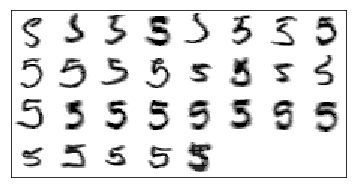

In [30]:
plot_digits(xtest[(yhat1==3)&(ytest==5)],images_per_row=8)
plt.show()

In [31]:
import cv2
import numpy as np

ml_trainx=np.append(xtrain1,xtrain1_,axis=0).reshape((-1,28*28))
ml_trainy=np.append(ytrain1,ytrain1,axis=0)


In [32]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (7,7)
cellSize = (14,14)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradients = True

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,
                        cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,
                        gammaCorrection,nlevels,signedGradients)
print(ml_trainx.shape)
descriptor = hog.compute(
    (ml_trainx[0]*255).astype(np.uint8).reshape((28,28)))



def hog_feature_extract(x):
    features=np.array([])
    for i,sample in enumerate(x):
        fea=hog.compute((sample*255).astype(np.uint8).reshape((28,28))).reshape((81,))
        features=np.append(features,fea,axis=0)
    return features


(139992, 784)


In [ ]:
train_Features=hog_feature_extract(ml_trainx)
import pickle
pickle.dump(train_Features, 
            open(r"/Users/aarontom/DeepLearning/Assignment 1/hogFeatures.pickle.dat", "wb"))

In [35]:
import pickle
train_Features=pickle.load(
    open(r"/Users/aarontom/DeepLearning/Assignment 1/hogFeatures.pickle.dat", "rb"))
train_Features=train_Features.reshape((-1,81))

In [36]:
test_Features=hog_feature_extract(xtest)
test_Features=test_Features.reshape((-1,81))

In [90]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, 
                                 bootstrap=True,
                                 criterion='gini',
                                 n_jobs=-1,
                                 random_state=20)

rnd_clf.fit(train_Features, ml_trainy)
pickle.dump(rnd_clf, 
            open(r"/Users/aarontom/DeepLearning/Assignment 1/rnd_clf.pickle.dat", "wb"))

In [37]:
rnd_clf=pickle.load(
    open(r"/Users/aarontom/DeepLearning/Assignment 1/rnd_clf.pickle.dat", "rb"))

In [38]:
ml_y_hat = rnd_clf.predict(test_Features)
conf_mx_hog=confusion_matrix(ytest,ml_y_hat)

print(sum(ml_y_hat!=ytest))
print(sum(yhat1!=ytest))
print(sum(yhat!=ytest))
print(conf_mx_hog)

190
234
309
[[ 972    0    3    1    0    0    3    0    1    0]
 [   0 1122    1    2    0    0    3    4    3    0]
 [   1    0 1024    2    1    0    1    2    0    1]
 [   0    0    0 1006    0    2    0    1    0    1]
 [   0    0    0    0  970    0    3    0    2    7]
 [   1    0    0   13    0  877    0    0    1    0]
 [   5    1    1    0    1    3  943    0    4    0]
 [   0    0   14    2    2    1    0  999    0   10]
 [   8    0    6   13    8    8    0    5  921    5]
 [   1    1    2    5    4    4    0    5   11  976]]


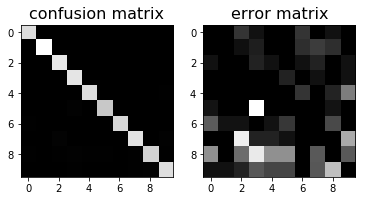

In [39]:
plt.subplot(1,2,1)
plt.title("confusion matrix", fontsize=16)
plt.imshow(conf_mx_hog, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.title("error matrix", fontsize=16)
row_sums1 = conf_mx_hog.sum(axis=1, keepdims=True)
norm_conf_mx_hog = conf_mx_hog / row_sums1
np.fill_diagonal(norm_conf_mx_hog, 0)
plt.imshow(norm_conf_mx_hog, cmap=plt.cm.gray)
plt.show()

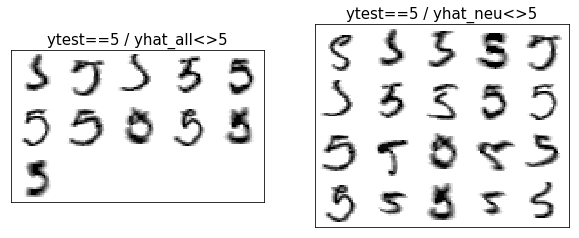

In [40]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('ytest==5 / yhat_all<>5', fontsize=15)
plot_digits(xtest[(ytest==5)&(ml_y_hat!=5)&(yhat1!=5)][:20],images_per_row=5)
plt.subplot(1,2,2)
plt.title('ytest==5 / yhat_neu<>5', fontsize=15)
plot_digits(xtest[(ytest==5)&(yhat1!=5)][:20],images_per_row=5)
plt.show()

We can see that ensembling method can increase.                   

* In this homework, we use SMOTE to generate new images. However GANs is another method to generate new images, and this can be done in the future.
* The best result can be found on http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html.

# Realization of Layers

### 1. FC Layer
##### Forward:
$$y=wx+b^T$$

##### Backward:
$$\frac{\partial J}{\partial x}=\frac{\partial J}{\partial y'}w^T $$
$$\frac{\partial J}{\partial w}=x^T\frac{\partial J}{\partial y'} $$
$$\frac{\partial J}{\partial b}=np.sum(\frac{\partial J}{\partial y'},axis=0) $$

### 2. Convolution Layer
##### Forward:
$$y=wx_{col}+b^T$$

##### Backward:
$$\frac{\partial J}{\partial x}=\frac{\partial J}{\partial y'}w^T $$
$$\frac{\partial J}{\partial w}=x^T\frac{\partial J}{\partial y'} $$
$$\frac{\partial J}{\partial b_i}=np.sum(\frac{\partial J}{\partial y'}, axis=(0,2,3)) $$

### 3. Relu
##### Forward:
$$
y = \left\{
        \begin{array}{ll}
            0 & \quad x \leq 0 \\
            x & \quad x > 0
        \end{array}
    \right.
$$

##### Backward:
$$
\frac{\partial J}{\partial x}=\left\{
        \begin{array}{ll}
            0 & \quad x \leq 0 \\
            \frac{\partial J}{\partial y'} & \quad x > 0
        \end{array}
    \right.
$$

### 4. Dropout
##### Forward:

Training:y=x\*mask  mask=(np.random.rand(\*x.shape)<p)/p, p is threadshold

Test:y=x

##### Backward:

Training:
$$\frac{\partial J}{\partial x}=\frac{\partial J}{\partial y'}*mask $$
Test:
$$\frac{\partial J}{\partial x}=\frac{\partial J}{\partial y'} $$

### 5. MaxPooling
##### Forward:
$$
y[n,c,h/p,w/p]=max(x[n,c,h:h+pool\_height,w:w+pool\_width])
$$
##### Backward:
$$
\frac{\partial J}{\partial x}[n,c,h',w']+=\frac{\partial J}{\partial y'}[n,c,h,w]
$$
$$
if \ \ \ \ h'=argmax(x[n,c,h*p:h*p+pool\_height,w*p:w*p+pool\_width])_{height}
$$
$$
and \ \ \ \ w'=argmax(x[n,c,h*p:h*p+pool\_height,w*p:w*p+pool\_width])_{width}
$$
$$
\frac{\partial J}{\partial x}[n,c,h',w']=0
$$
$$
if \ \ \ \ \ h'!=argmax(x[n,c,h*p:h*p+pool\_height,w*p:w*p+pool\_width])_{height}
$$
$$
and \ \ \ \ \ w'!=argmax(x[n,c,h*p:h*p+pool\_height,w*p:w*p+pool\_width])_{width}
$$
$$h'\in[h*p,h*p+pool\_height],$$
$$w'\in[w*p:w*p+pool\_width]$$

### 6. AvePooling
##### Forward:
$$
y[n,c,h/p,w/p]=avg(x[n,c,h:h+pool\_height,w:w+pool\_width])
$$
##### Backward:
$$
\frac{\partial J}{\partial x}[n,c,k,l]+=\frac{\partial J}{\partial y'}[n,c,i,j]/(pool\_height*pool\_width)
$$
$$i\in range(0,H+2*pad-pool\_height+stride,stride),$$
$$j\in range(0,W+2*pad-pool\_width+stride,stride),$$
$$k\in [i*stride,min(i*stride+pool_height,H)],$$
$$l\in [j*stride,min(j*stride+pool_width,W)]$$

### 6. Softmax
##### Forward:
The basic softmax function is:
\begin{equation}
y_i=\frac{e^{x_i}}{\sum_{k=1}^N e^{x_k}}
\end{equation}
To make the softmax function numerically stable, we simply normalize the values in the vector, by multiplying the numerator and denominator with a constant C
\begin{equation}
y_i=\frac{Ce^{x_i}}{C\sum_{k=1}^N e^{x_k}}=\frac{e^{x_i+log(C)}}{\sum_{k=1}^N e^{x_k+log(C)}}
\end{equation}
We can choose an arbitrary value for log(C) term, but generally log(C)=−max(x), as it shifts all of elements in the vector to negative to zero, and negatives with large exponents saturate to zero rather than the infinity, avoiding overflowing and resulting in nan.
##### Backward:
$$\frac{\partial y_j}{\partial x_i}=y_j(1-y_i) \ \ \ \ \ \ if i=j,$$
$$\frac{\partial y_j}{\partial x_i}=-y_j.y_i \ \ \ \ \ \ if i<>j$$
In the homework, out_grads in this layer conresponds to Gradient of the loss with respect to scores which is used to caculate the softmax value:
\begin{equation}
probs_j=\frac{e^{scores_i-max(scores)}}
{\sum_{k=1}^N e^{scores_k-max(scores)}}
\end{equation}
Therefore:
\begin{equation}
\frac{\partial loss_j}{\partial score_i}=\frac{\partial loss_j}{\partial probs_j}\frac{\partial probs_j}{\partial score_i}=(\frac{-1}N\frac1{y_i})y_i(\delta_{ij}-y_j) \\
\delta_{ij}=\left\{
        \begin{array}{ll}
            1 & \quad i = j \\
            0 & \quad i <> j
        \end{array}
    \right.
\end{equation}
This is out_grads.

### 7. Optimizer
##### SGD
$$v_t=\gamma v_{t-1}+\eta \nabla_\theta J(\theta)$$
$$\theta_t=\theta_{t-1}+\gamma v_t-\eta \nabla_\theta J(\theta)$$
##### Adam
$$v=(1-\beta_1)v+\beta_1g$$
$$s=(1-\beta_2)s+\beta_2g^2$$
$$w=w-\alpha\frac{\dot{v}}{\sqrt{\dot{S}+\epsilon}}$$
##### We find that in Keras, it doesn't implement: (See Reference below)
$$\dot{v_t}=\frac{v_t}{1-\beta^t_1}$$
$$\dot{s_t}=\frac{s_t}{1-\beta^t_2}$$

### Reference
* https://madalinabuzau.github.io/2016/11/29/gradient-descent-on-a-softmax-cross-entropy-cost-function.html
* https://deepnotes.io/softmax-crossentropy
* https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/
* http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/
* https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/model_optimization.html
* http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.over_sampling.SMOTE.html
* http://ruder.io/optimizing-gradient-descent/index.html#momentum
* https://docs.opencv.org/3.4.0/dd/d3b/tutorial_py_svm_opencv.html
* https://github.com/keras-team/keras/blob/master/keras/optimizers.py#L126
* Hands-On Machine Learning with Scikit-Learn and TensorFlow
* Practical Machine Learning with Python
* Deep Learning with Keras

# Final submission instructions
Please submit the following:

1) Your code files in a folder `codes`

2) A short report (1-2 pages) in pdf titled `report.pdf`, explaining the logic (expressed using mathematical formulation) of your implementation (including the forward and backward function like ReLU) and the findings from training your best net

**ASSIGNMENT DEADLINE: 4 MAR 2018 (SUN) 17:00PM**

Do not include the `data` folder as it takes up substantial memory. Please zip up the following folders under a folder named with your NUSNET ID: eg. `e0123456g.zip' and submit the zipped folder to IVLE/workbin/assignment 1 submission.